# SFRD from IR based data

Until now, we have been using UV observations to determine the luminosity functions and SFRDs from it. Now, let's turn our attention to the IR data. We currently have three references for such observations. We, for now, focus on these data. We try to propagate the errors correctly. Below, we show the results of this computation which were done using the code presented [here](https://github.com/Jayshil/csfrd/blob/main/c2_irlf_grp.py) and [here](https://github.com/Jayshil/csfrd/blob/main/p9_IR_SFRDs.ipynb). Here we do not assume any correlation among the luminosity function parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as utl
import astropy.constants as con
import astropy.units as u
from scipy.optimize import minimize as mz
from scipy.optimize import curve_fit as cft
import os

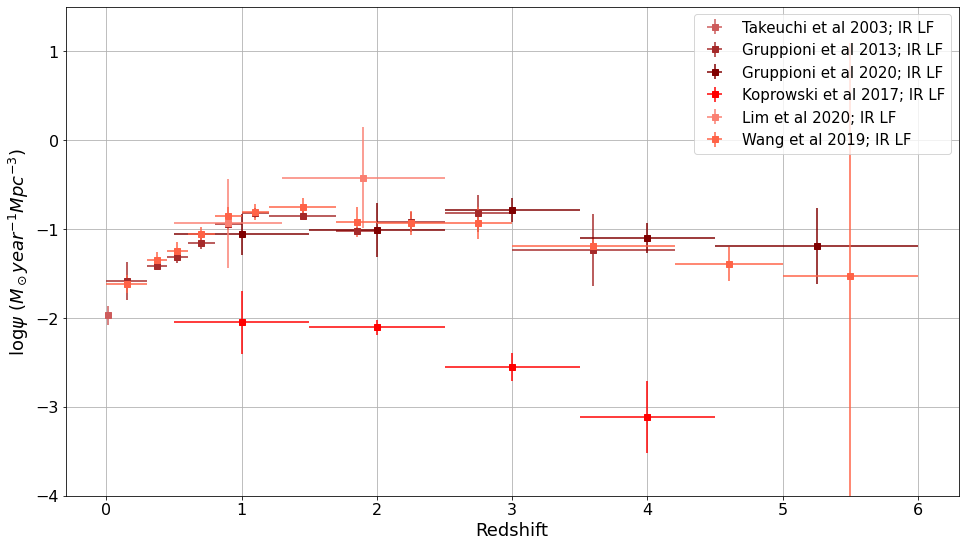

In [2]:
p2 = os.getcwd()
ppr_ir = np.array(['Takeuchi_et_al_2003', 'Gruppioni_et_al_2013', 'Gruppioni_et_al_2020', 'Koprowski_et_al_2017', 'Lim_et_al_2020', 'Wang_et_al_2019'])

cols = np.array(['indianred','brown','maroon','red','salmon','tomato'])

# Loading papers
ppr_ir1 = np.loadtxt(p2 + '/sfrd_ir_new.dat', usecols=0, unpack=True, dtype=str)
zd_ir, zu_ir, sfrd_ir, sfrd_ir_err = np.loadtxt(p2 + '/sfrd_ir_new.dat', usecols=(1,2,3,4), unpack=True)
zcen_ir = (zd_ir + zu_ir)/2
zup, zdo = np.abs(zu_ir - zcen_ir), np.abs(zcen_ir - zd_ir)
log_sfrd_ir, log_sfrd_ir_err = utl.log_err(sfrd_ir, sfrd_ir_err)


plt.figure(figsize=(16, 9))
# Plotting them
for i in range(len(ppr_ir)):
    zc_ir, zp, zn, lg_sf, lg_sfe = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    for j in range(len(ppr_ir1)):
        if ppr_ir1[j] == ppr_ir[i]:
            zc_ir = np.hstack((zc_ir, zcen_ir[j]))
            lg_sf = np.hstack((lg_sf, log_sfrd_ir[j]))
            lg_sfe = np.hstack((lg_sfe, log_sfrd_ir_err[j]))
            zp = np.hstack((zp, zup[j]))
            zn = np.hstack((zn, zdo[j]))
    plt.errorbar(zc_ir, lg_sf, xerr=[zn, zp], yerr=lg_sfe, c=cols[i], label=ppr_ir[i].replace('_',' ') + '; IR LF', fmt='.', marker='s')

#plt.plot(znew, psi2, label='Best fitted function')
plt.xlabel('Redshift', fontsize= 18)
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)', fontsize= 18)
plt.ylim([-4.0, 1.5])
plt.grid()
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.legend(loc='best', fontsize= 15)#, bbox_to_anchor=(1.05, 1))

In this case, the original function from Madau & Dickinson (2014) should fit properly... Let's check that!

In [3]:
# Defining best-fitted SFRD

def psi_md(z):
    ab = (1+z)**2.7
    cd = ((1+z)/2.9)**5.6
    ef = 0.015*ab/(1+cd)
    return ef

# Calculating psi(z)
znew = np.linspace(0,6,1000)
psi1 = psi_md(znew)
psi2 = np.log10(psi1)

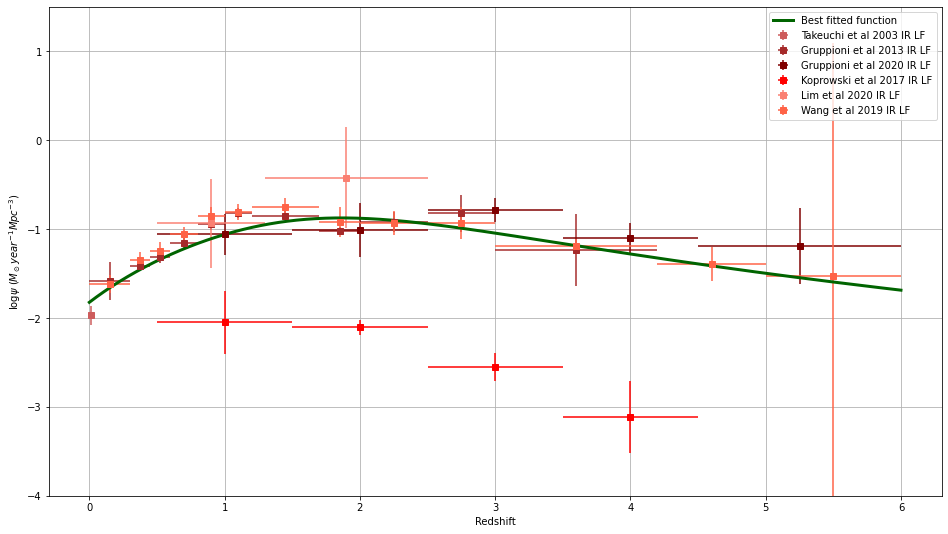

In [4]:
plt.figure(figsize=(16, 9))
plt.plot(znew, psi2, label='Best fitted function', c='darkgreen', lw=3)
# Plotting them
for i in range(len(ppr_ir)):
    zc_ir, zp, zn, lg_sf, lg_sfe = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    for j in range(len(ppr_ir1)):
        if ppr_ir1[j] == ppr_ir[i]:
            zc_ir = np.hstack((zc_ir, zcen_ir[j]))
            lg_sf = np.hstack((lg_sf, log_sfrd_ir[j]))
            lg_sfe = np.hstack((lg_sfe, log_sfrd_ir_err[j]))
            zp = np.hstack((zp, zup[j]))
            zn = np.hstack((zn, zdo[j]))
    plt.errorbar(zc_ir, lg_sf, xerr=[zn, zp], yerr=lg_sfe, c=cols[i], label=ppr_ir[i].replace('_',' ') + ' IR LF', fmt='.', marker='s')

plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.ylim([-4.0, 1.5])
plt.grid()
plt.legend(loc='best')

We can do better by fitting this Madau & Dickinson (2014) curve to the data, which we do below. Just as in the case of UV data, we assumes the form of Madau & Dickinson (2014),

$$ \psi(z) = A \frac{(1+z)^{B}}{1 + [(1+z)/C]^{D}} M_\odot \ year^{-1} Mpc^{-3}$$

however, make the exponents variable.

In [5]:
# New model
def psi_new(z, aa, bb, cc, dd):
    ab = (1+z)**bb
    cd = ((1+z)/cc)**dd
    ef = aa*ab/(1+cd)
    return ef

# Negative likelihood function
def min_log_likelihood(x):
    model = psi_new(zcen_ir, x[0], x[1], x[2], x[3])
    chi2 = (sfrd_ir - model)#/sfrd_ir_err
    chi22 = np.sum(chi2**2)
    yy = 0.5*chi22 #+ np.sum(np.log(sfrd_ir_err))
    return yy

xinit, pcov = cft(psi_new, zcen_ir, sfrd_ir, sigma=sfrd_ir_err, maxfev=10000)
#xinit = np.array([0.015, 2.7, 2.9, 5.6])
#xinit = np.array([0.01, 3., 3., 6.])
soln = mz(min_log_likelihood, xinit, method='L-BFGS-B')
soln

ipykernel_launcher:4: RuntimeWarning: invalid value encountered in power


      fun: 0.05705892226401193
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.37893169e-04, 1.16365251e-06, 1.37459488e-06, 4.72538675e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 345
      nit: 54
   status: 0
  success: True
        x: array([0.01276551, 3.59557559, 2.39881507, 5.86916365])

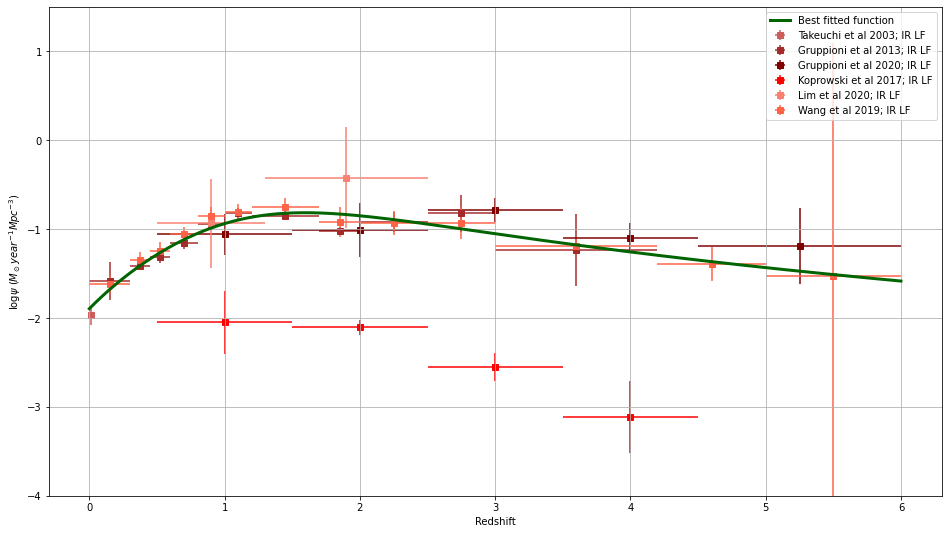

In [6]:
best_fit_fun = psi_new(znew, *soln.x)
log_best_fit = np.log10(best_fit_fun)

plt.figure(figsize=(16,9))
plt.plot(znew, log_best_fit, label='Best fitted function', lw=3, c='darkgreen',zorder=5)

# Plotting them
for i in range(len(ppr_ir)):
    zc_ir, zp, zn, lg_sf, lg_sfe = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    for j in range(len(ppr_ir1)):
        if ppr_ir1[j] == ppr_ir[i]:
            zc_ir = np.hstack((zc_ir, zcen_ir[j]))
            lg_sf = np.hstack((lg_sf, log_sfrd_ir[j]))
            lg_sfe = np.hstack((lg_sfe, log_sfrd_ir_err[j]))
            zp = np.hstack((zp, zup[j]))
            zn = np.hstack((zn, zdo[j]))
    plt.errorbar(zc_ir, lg_sf, xerr=[zn, zp], yerr=lg_sfe, c=cols[i], label=ppr_ir[i].replace('_',' ') + '; IR LF', fmt='.', marker='s', zorder=1)

plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.ylim([-4.0, 1.5])
plt.legend(loc='best')
plt.grid()

In this case, the best fitted function would be,

$$ \psi(z) = 0.013 \frac{(1+z)^{3.60}}{1 + [(1+z)/2.40]^{5.87}} M_\odot \ year^{-1} Mpc^{-3}$$